C:\Users\hethe\AppData\Local\Temp\ipykernel_14288\3532553372.py:14: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('master.csv')


Metrics for HistGradientBoosting:
  Mean Absolute Error (MAE): 3.974
  Mean Squared Error (MSE): 33.224
  Root Mean Squared Error (RMSE): 5.764
  R-squared (R2): 0.620
  Mean Absolute Percentage Error (MAPE): 50.732%

Metrics for XGBoost:
  Mean Absolute Error (MAE): 3.677
  Mean Squared Error (MSE): 30.219
  Root Mean Squared Error (RMSE): 5.497
  R-squared (R2): 0.654
  Mean Absolute Percentage Error (MAPE): 43.301%

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1435
[LightGBM] [Info] Number of data points in the train set: 46420, number of used features: 15
[LightGBM] [Info] Start training from score 12.655106
Metrics for LightGBM:
  Mean Absolute Error (MAE): 3.967
  Mean Squared Error (MSE): 33.123
  Root Mean Squared Error (RMSE): 5.755
  R-squared (R2): 0.62

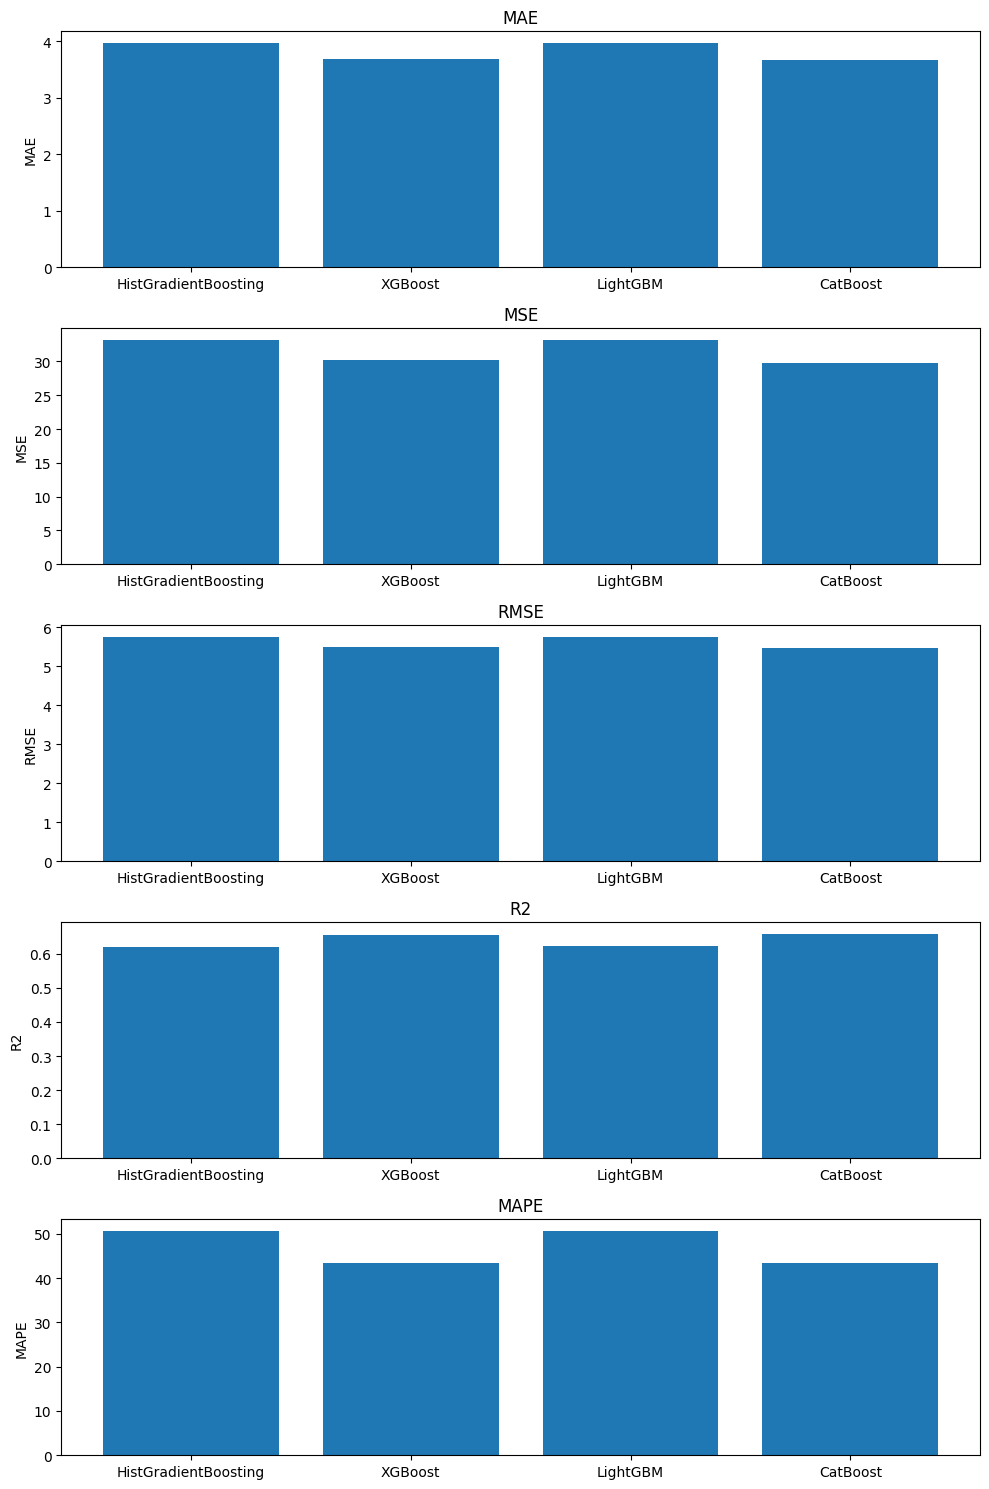

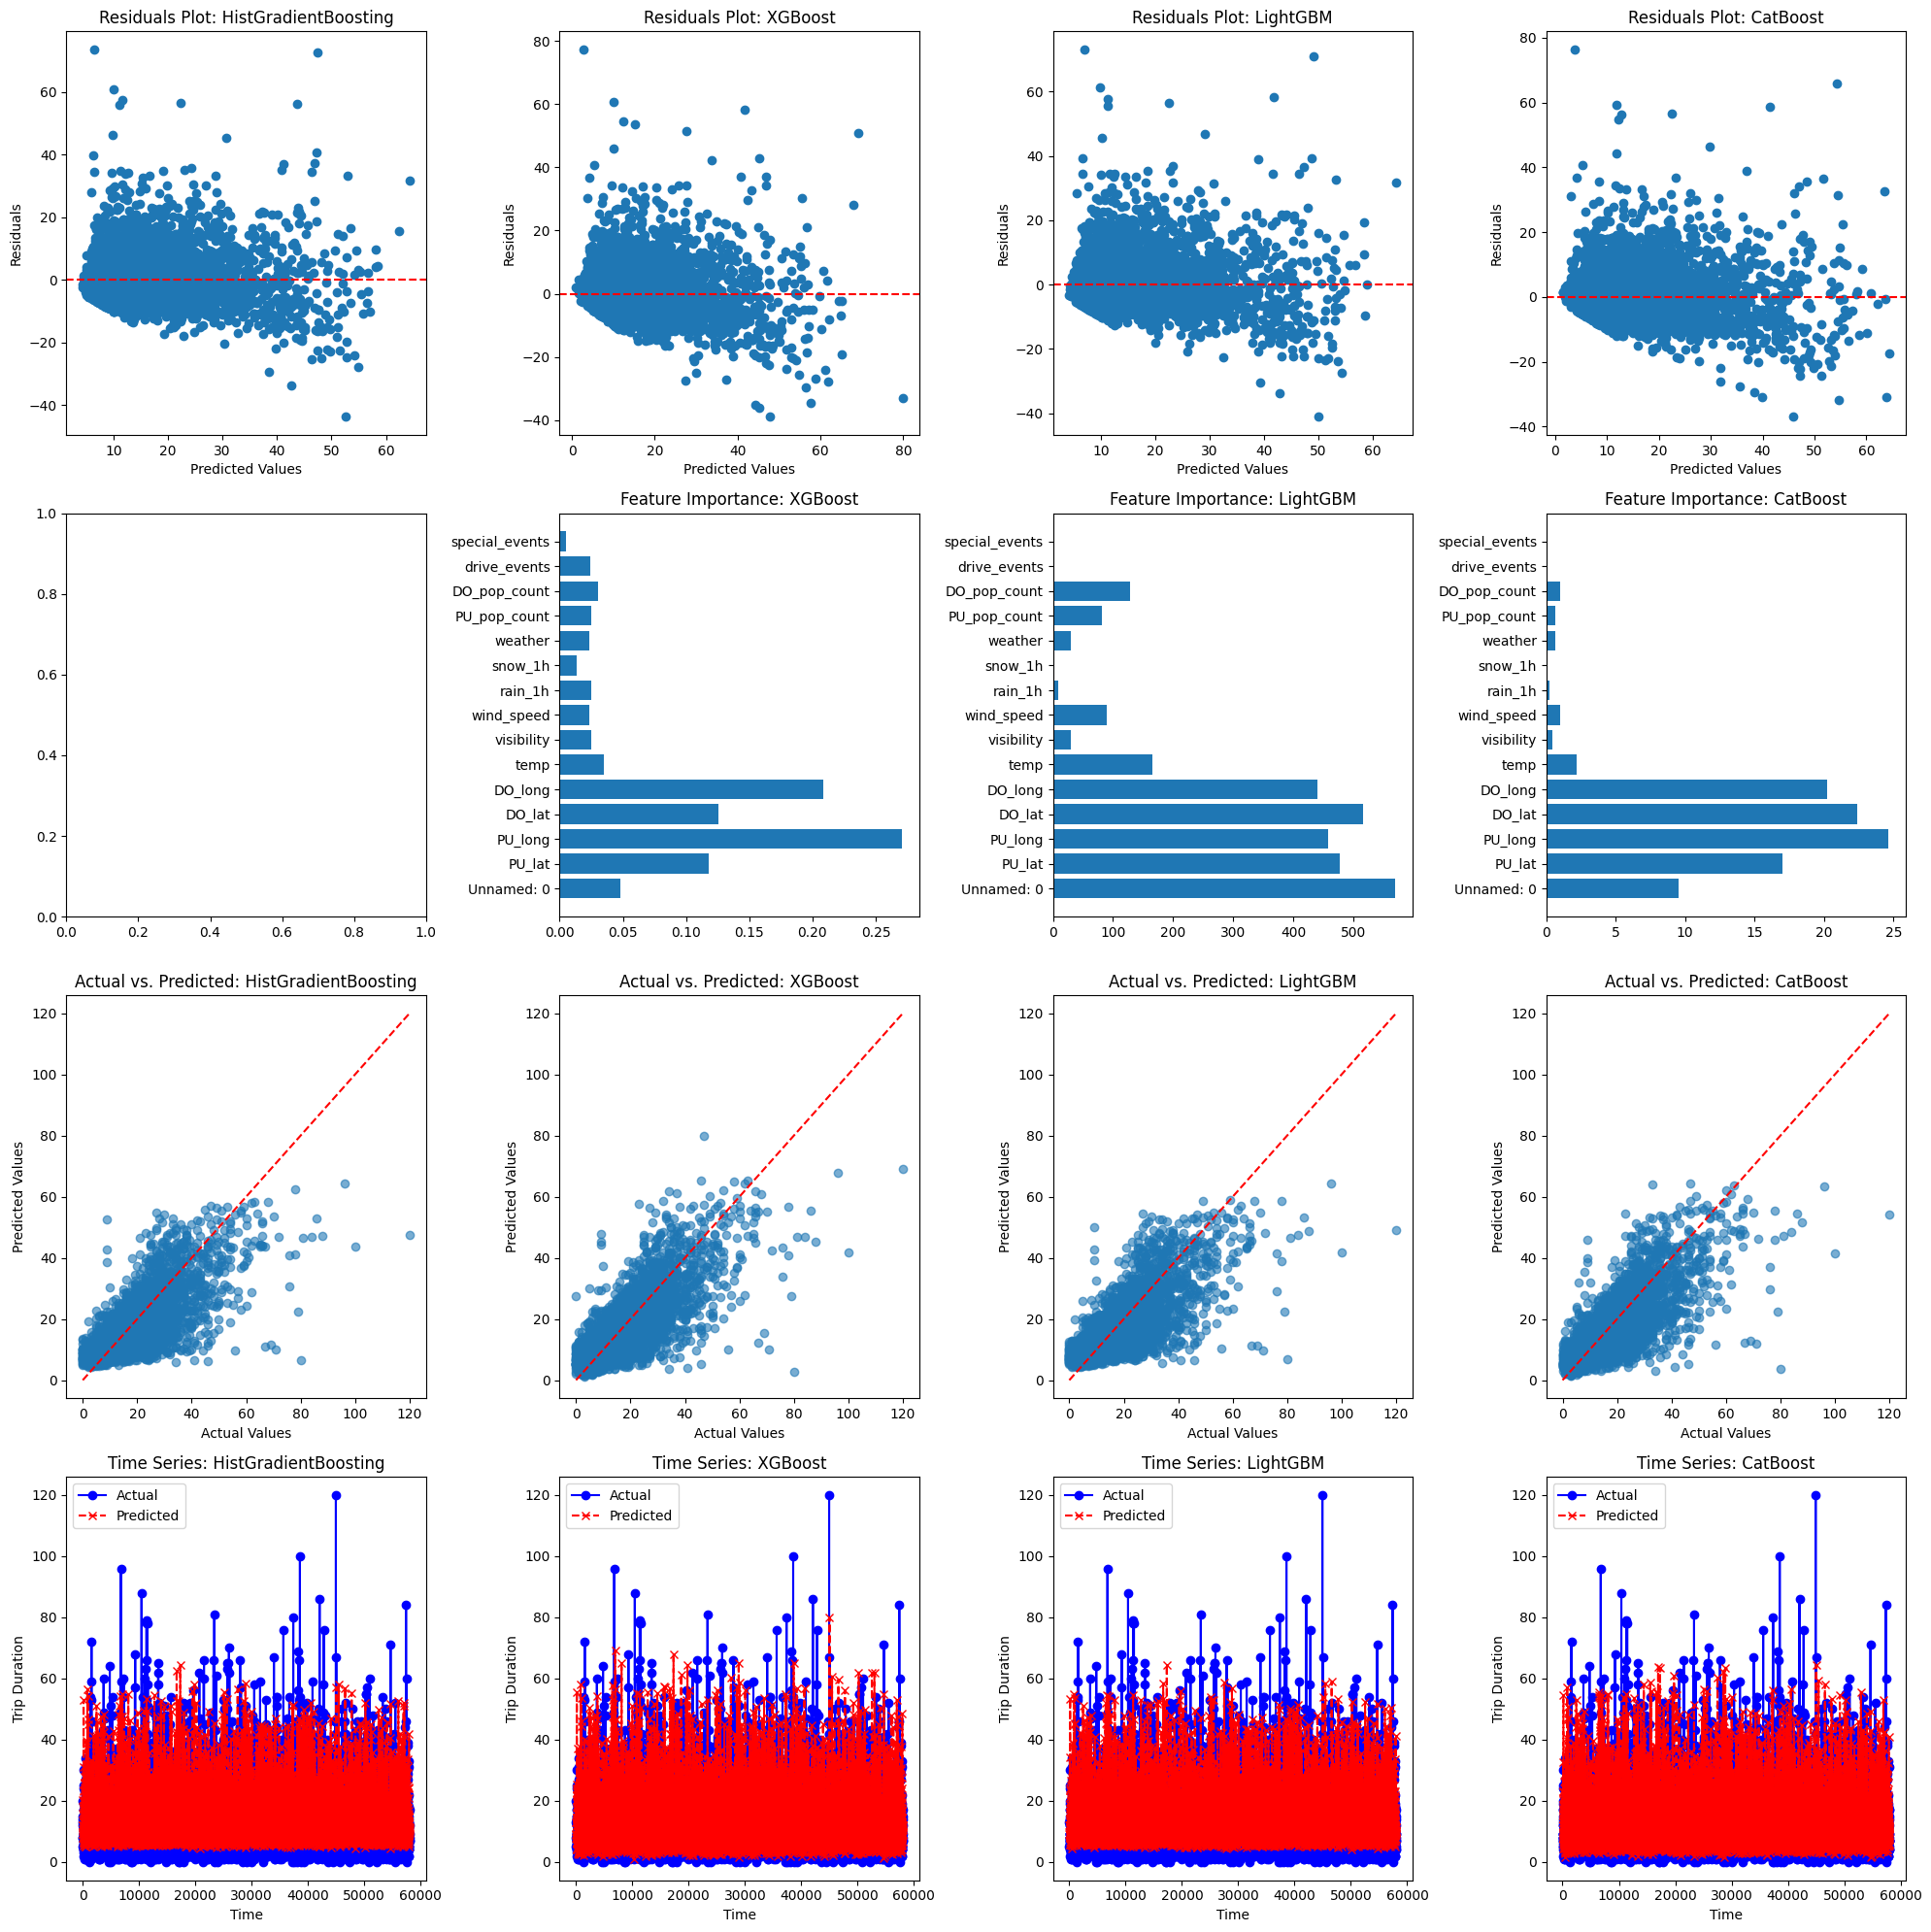

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load and preprocess data
data = pd.read_csv('master.csv')

# Encode categorical variables
label_encoders = {}
for column in ['weather', 'special_events', 'drive_events']:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Convert datetime and calculate duration
data['start_datetime'] = pd.to_datetime(data['start_datetime'])
data['end_datetime'] = pd.to_datetime(data['end_datetime'])
data['trip_duration'] = (data['end_datetime'] - data['start_datetime']).dt.total_seconds() / 60.0  # duration in minutes

# Drop unnecessary columns
data = data.drop(['start_datetime', 'end_datetime', 'trip_distance'], axis=1)

# Define features and target
X = data.drop('trip_duration', axis=1)
y = data['trip_duration']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Clean column names if needed
X_train.columns = [col.replace('{', '').replace('}', '').replace(':', '').replace(',', '_') for col in X_train.columns]
X_test.columns = [col.replace('{', '').replace('}', '').replace(':', '').replace(',', '_') for col in X_test.columns]

# Define models
models = {
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42, missing=np.nan),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'CatBoost': cb.CatBoostRegressor(random_state=42, verbose=0)
}

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    if np.any(non_zero_mask):
        return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    else:
        return np.nan

# Train models and print metrics
results = {}
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

    print(f"Metrics for {name}:")
    print(f"  Mean Absolute Error (MAE): {mae:.3f}")
    print(f"  Mean Squared Error (MSE): {mse:.3f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"  R-squared (R2): {r2:.3f}")
    print(f"  Mean Absolute Percentage Error (MAPE): {mape:.3f}%\n")

# Plot metrics
metrics = ['MAE', 'MSE', 'RMSE', 'R2', 'MAPE']
fig, ax = plt.subplots(len(metrics), 1, figsize=(10, 15))
for i, metric in enumerate(metrics):
    ax[i].bar(results.keys(), [results[model][metric] for model in results])
    ax[i].set_title(metric)
    ax[i].set_ylabel(metric)
plt.tight_layout()
plt.show()

# Calculate metrics and plot residual, feature importance, comparison scatter plot, and time series plot
fig, axs = plt.subplots(4, len(models), figsize=(20, 20))
for idx, (name, y_pred) in enumerate(predictions.items()):
    # Residual Plot
    residuals = y_test - y_pred
    axs[0, idx].scatter(y_pred, residuals)
    axs[0, idx].axhline(0, color='red', linestyle='--')
    axs[0, idx].set_title(f'Residuals Plot: {name}')
    axs[0, idx].set_xlabel('Predicted Values')
    axs[0, idx].set_ylabel('Residuals')
    
    # Feature Importance (if applicable)
    if hasattr(models[name], 'feature_importances_'):
        importances = models[name].feature_importances_
        axs[1, idx].barh(range(len(importances)), importances)
        axs[1, idx].set_yticks(range(len(X.columns)))
        axs[1, idx].set_yticklabels(X.columns)
        axs[1, idx].set_title(f'Feature Importance: {name}')
    
    # Comparison Scatter Plot
    axs[2, idx].scatter(y_test, y_pred, alpha=0.6)
    axs[2, idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axs[2, idx].set_title(f'Actual vs. Predicted: {name}')
    axs[2, idx].set_xlabel('Actual Values')
    axs[2, idx].set_ylabel('Predicted Values')
    
    # Time Series Plot
    sorted_indices = y_test.sort_index().index
    axs[3, idx].plot(y_test.sort_index(), label='Actual', color='blue', marker='o')
    axs[3, idx].plot(pd.Series(y_pred, index=sorted_indices), label='Predicted', color='red', linestyle='--', marker='x')
    axs[3, idx].set_title(f'Time Series: {name}')
    axs[3, idx].set_xlabel('Time')
    axs[3, idx].set_ylabel('Trip Duration')
    axs[3, idx].legend()

plt.tight_layout()
plt.show()

